In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pydaptivefiltering as pdf

In [2]:
def generate_tracking_data(n_samples=200, dt=0.1):
    # Modelo: [posição, velocidade]
    A = np.array([[1.0, dt],
                  [0.0, 1.0]])
    C_T = np.array([[1.0, 0.0]]) # Medimos apenas posição
    
    # Covariâncias Reais
    Rn_real = np.array([[0.001, 0.0], [0.0, 0.001]])
    Rn1_real = np.array([[0.5]]) # Sensor bastante ruidoso
    
    x_true = np.zeros((n_samples, 2))
    y_meas = np.zeros(n_samples)
    
    curr_x = np.array([[0.0], [1.0]]) # Começa em 0m, a 1m/s
    
    for k in range(n_samples):
        # Evolução do sistema com ruído de processo
        process_noise = np.random.multivariate_normal([0, 0], Rn_real).reshape(2, 1)
        curr_x = A @ curr_x + process_noise
        
        # Medição com ruído de sensor
        measurement_noise = np.random.normal(0, np.sqrt(Rn1_real[0, 0]))
        y_meas[k] = (C_T @ curr_x).item() + measurement_noise
        
        x_true[k] = curr_x.flatten()
        
    return x_true, y_meas, A, C_T, Rn_real, Rn1_real

# Gerar os dados
n_samples = 200
dt = 0.1
x_true, y_meas, A, C_T, Rn, Rn1 = generate_tracking_data(n_samples, dt)

In [3]:
# Configuração do Filtro
x_init = np.array([[0.0], [0.0]]) # Chute inicial (estamos parados na origem)
Re_init = np.eye(2) * 10.0      # Incerteza inicial alta

# Instanciação (Certifique-se que a classe Kalman está definida ou importada)
kf = pdf.Kalman(A=A, C_T=C_T, Rn=Rn, Rn1=Rn1, x_init=x_init, Re_init=Re_init)

# Filtragem
results = kf.optimize(y_meas, verbose=True)

x_est = results.outputs      # Estimativas [pos, vel]
innovations = results.errors  # Erro de predição
cov_history = results.coefficients # Evolução da matriz Re

[Kalman] Completed in 5.657 ms


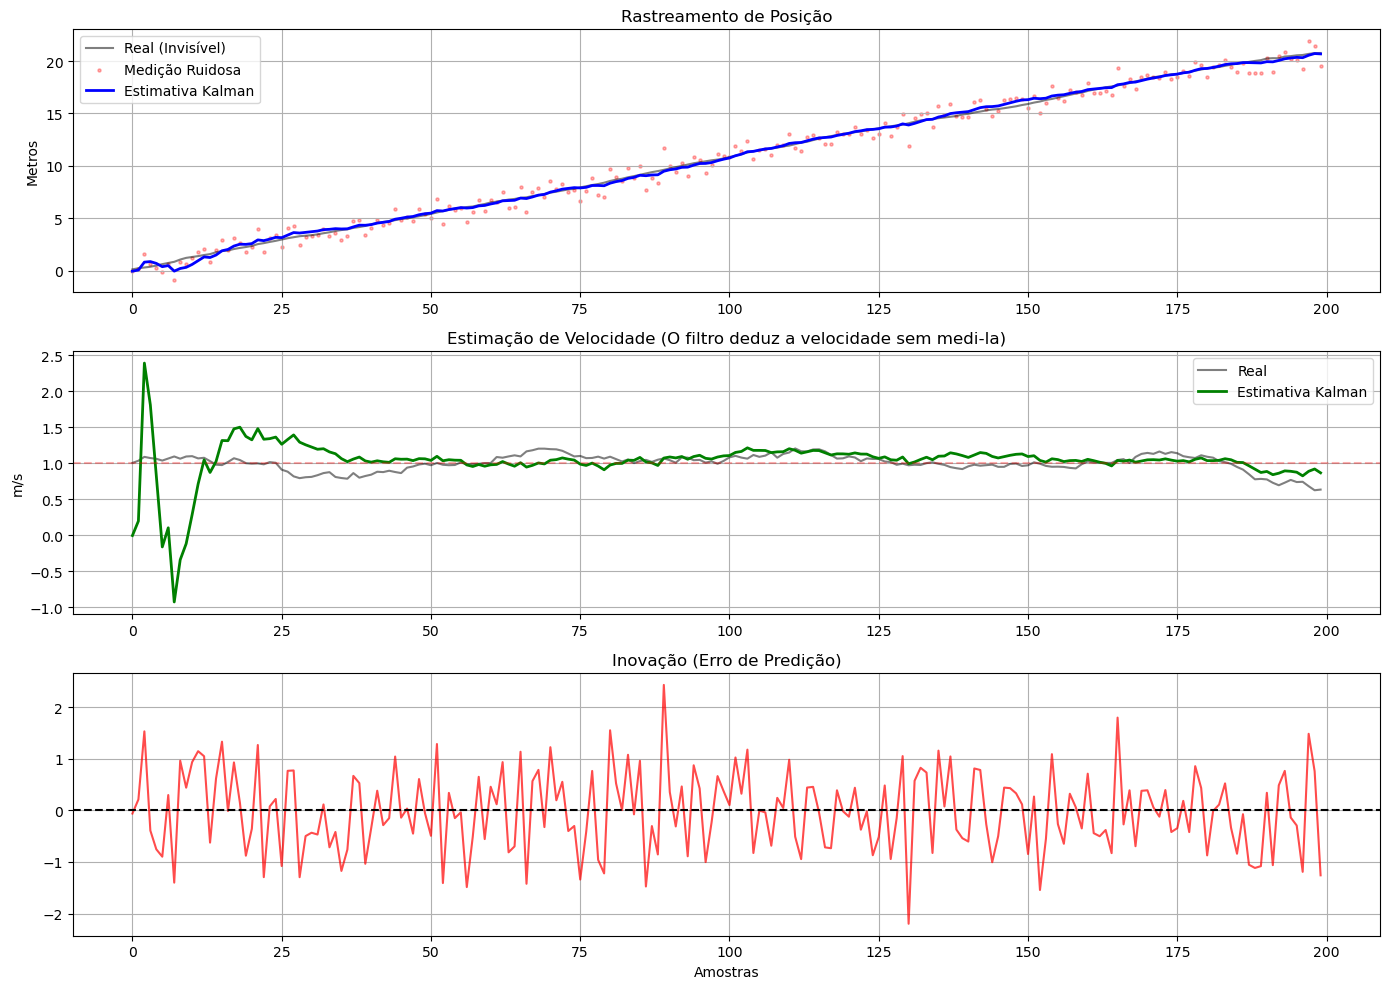

MSE Posição: 0.0498


In [4]:
plt.figure(figsize=(14, 10))

# Subplot 1: Posição
plt.subplot(3, 1, 1)
plt.plot(x_true[:, 0], 'k-', label='Real (Invisível)', alpha=0.5)
plt.scatter(range(n_samples), y_meas, color='red', s=5, alpha=0.3, label='Medição Ruidosa')
plt.plot(x_est[:, 0], 'b-', linewidth=2, label='Estimativa Kalman')
plt.title("Rastreamento de Posição")
plt.ylabel("Metros")
plt.legend()
plt.grid(True)

# Subplot 2: Velocidade (Variável Oculta)
plt.subplot(3, 1, 2)
plt.plot(x_true[:, 1], 'k-', alpha=0.5, label='Real')
plt.plot(x_est[:, 1], 'g-', linewidth=2, label='Estimativa Kalman')
plt.axhline(1.0, color='red', linestyle='--', alpha=0.3)
plt.title("Estimação de Velocidade (O filtro deduz a velocidade sem medi-la)")
plt.ylabel("m/s")
plt.legend()
plt.grid(True)

# Subplot 3: Inovação
plt.subplot(3, 1, 3)
# O .squeeze() remove dimensões unitárias, transformando (200, 1, 1) em (200,)
plt.plot(innovations.squeeze(), 'r', alpha=0.7) 
plt.axhline(0, color='black', linestyle='--')
plt.title("Inovação (Erro de Predição)")
plt.xlabel("Amostras")
plt.grid(True)

plt.tight_layout()
plt.show()

# Métricas de Erro
mse_pos = np.mean((x_true[:, 0] - x_est[:, 0])**2)
print(f"MSE Posição: {mse_pos:.4f}")

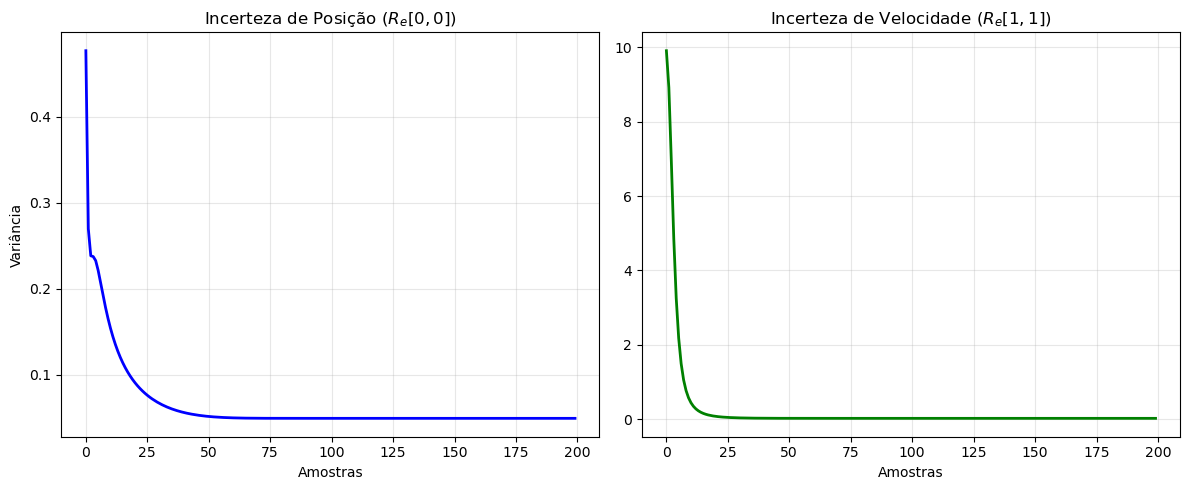

In [5]:
# Extrair a diagonal da matriz Re (Variâncias de posição e velocidade)
# Re_history é uma lista de matrizes (N, n, n)
re_array = np.array(results.coefficients)

var_pos = re_array[:, 0, 0] # Variância da Posição
var_vel = re_array[:, 1, 1] # Variância da Velocidade

plt.figure(figsize=(12, 5))

# Plot da Incerteza de Posição
plt.subplot(1, 2, 1)
plt.plot(var_pos, color='blue', lw=2)
plt.title("Incerteza de Posição ($R_e[0,0]$)")
plt.xlabel("Amostras")
plt.ylabel("Variância")
plt.grid(True, alpha=0.3)

# Plot da Incerteza de Velocidade
plt.subplot(1, 2, 2)
plt.plot(var_vel, color='green', lw=2)
plt.title("Incerteza de Velocidade ($R_e[1,1]$)")
plt.xlabel("Amostras")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Teste 2


In [7]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_cv_1d(N=300, dt=1.0, q=1e-3, r=1e-1, x0=np.array([0.0, 1.0]), seed=0):
    """
    Constant-velocity model (CV) in 1D:
        x = [position, velocity]^T
        x_{k} = A x_{k-1} + w_k
        y_k   = C^T x_k + v_k   (measures position)
    w ~ N(0, Q), v ~ N(0, R)
    """
    rng = np.random.default_rng(seed)

    A = np.array([[1.0, dt],
                  [0.0, 1.0]])
    C_T = np.array([[1.0, 0.0]])  # (p=1, n=2)

    # Process noise: assume acceleration noise -> Q structure
    Q = q * np.array([[dt**4/4, dt**3/2],
                      [dt**3/2, dt**2]])
    R = np.array([[r]])

    x_true = np.zeros((N, 2))
    y_meas = np.zeros((N, 1))

    x = x0.astype(float).copy()
    for k in range(N):
        # process noise
        w = rng.multivariate_normal(mean=[0.0, 0.0], cov=Q).reshape(2,)

        x = A @ x + w
        x_true[k, :] = x

        # measurement noise
        v = rng.normal(loc=0.0, scale=np.sqrt(r))
        y_meas[k, 0] = (C_T @ x.reshape(-1,1))[0,0] + v

    return A, C_T, Q, R, x_true, y_meas


def test_kalman_cv(pdf, N=300, dt=1.0, q=1e-3, r=1e-1, seed=0, plot=True):
    """
    pdf: módulo pydaptivefiltering (ex: import pydaptivefiltering as pdf)
    """
    A, C_T, Rn, Rn1, x_true, y_meas = simulate_cv_1d(N=N, dt=dt, q=q, r=r, seed=seed)

    x_init = np.array([0.0, 0.0])
    Re_init = np.eye(2) * 10.0

    kf = pdf.Kalman(A=A, C_T=C_T, Rn=Rn, Rn1=Rn1, x_init=x_init, Re_init=Re_init)
    res = kf.optimize(y_meas, verbose=True)

    x_hat = res.outputs          # (N,2)
    innov = res.errors           # (N,1)

    # métricas simples
    rmse_pos = np.sqrt(np.mean((x_hat[:,0] - x_true[:,0])**2))
    rmse_vel = np.sqrt(np.mean((x_hat[:,1] - x_true[:,1])**2))
    innov_var = float(np.var(innov[int(N*0.2):, 0]))

    if plot:
        t = np.arange(N) * dt
        plt.figure(figsize=(12, 4))
        plt.plot(t, x_true[:,0], label="pos true")
        plt.plot(t, y_meas[:,0], ".", alpha=0.3, label="pos meas")
        plt.plot(t, x_hat[:,0], label="pos est")
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.title("Kalman CV 1D: Posição")
        plt.show()

        plt.figure(figsize=(12, 4))
        plt.plot(t, x_true[:,1], label="vel true")
        plt.plot(t, x_hat[:,1], label="vel est")
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.title("Kalman CV 1D: Velocidade")
        plt.show()

        plt.figure(figsize=(12, 3))
        plt.plot(innov[:,0], lw=0.8)
        plt.grid(True, alpha=0.3)
        plt.title("Inovação e[k] = y[k] - C^T x_pred")
        plt.show()

    return {
        "rmse_pos": rmse_pos,
        "rmse_vel": rmse_vel,
        "innov_var_tail": innov_var,
        "res": res,
        "x_true": x_true,
        "y_meas": y_meas,
    }


[Kalman] Completed in 6.722 ms


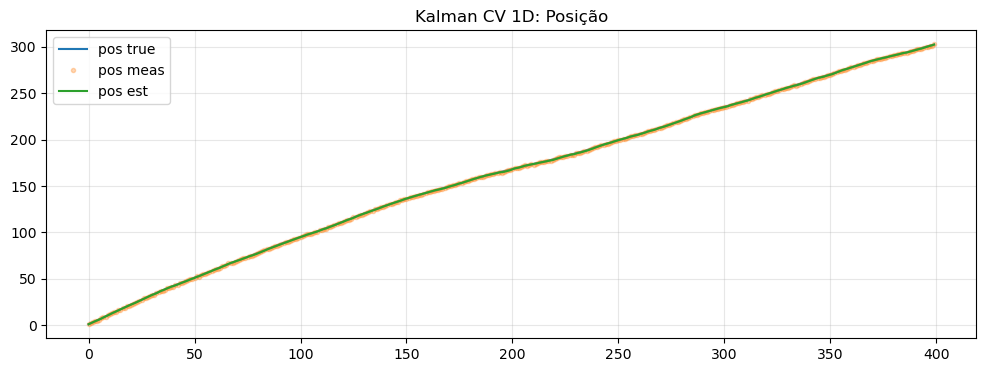

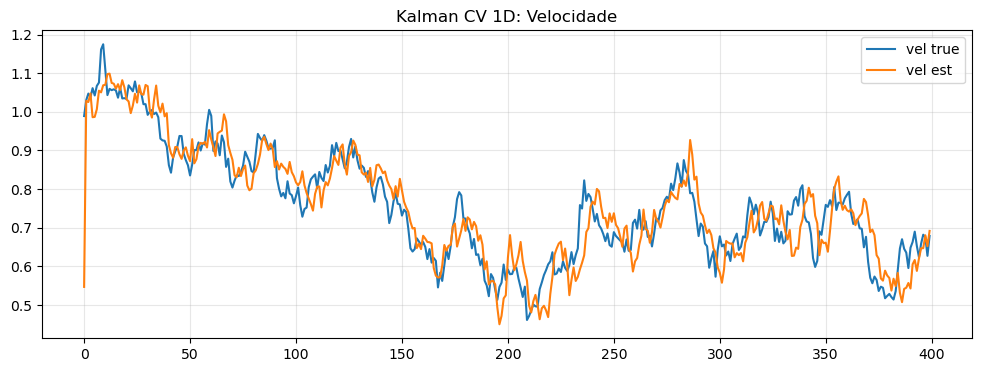

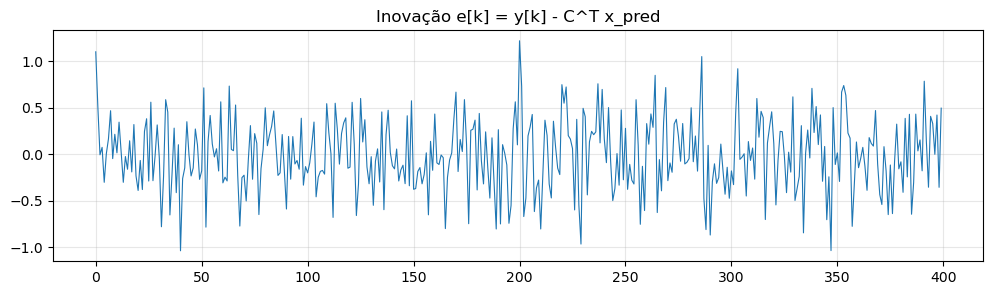

(0.1964669520366819, 0.0629821834234058, 0.15445880683098595)

In [8]:
out = test_kalman_cv(pdf, N=400, q=1e-3, r=1e-1, seed=1, plot=True)
out["rmse_pos"], out["rmse_vel"], out["innov_var_tail"]

# Teste 3

[Kalman] Completed in 10.481 ms


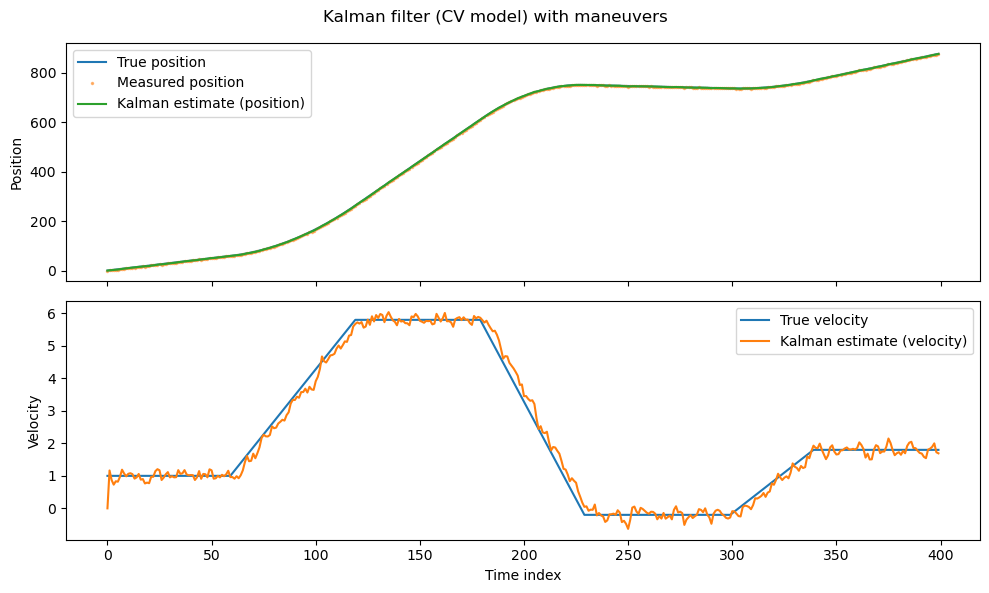

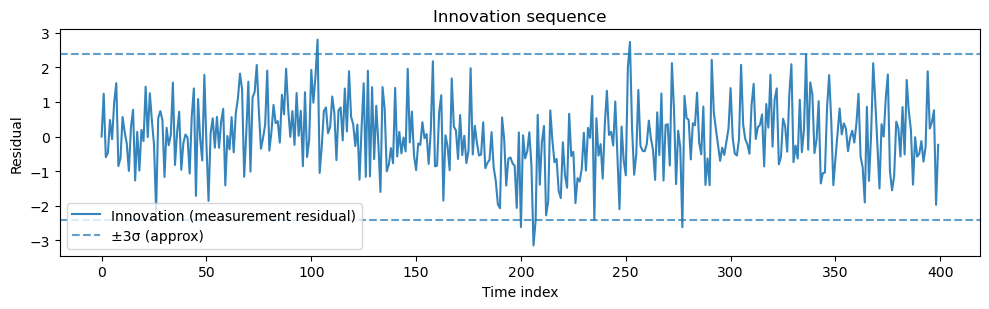

In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pydaptivefiltering as pdf

# -----------------------------
# 1) Simulação: alvo com manobras
# -----------------------------
rng = np.random.default_rng(7)

N = 400
dt = 1.0

# Estado verdadeiro: [pos, vel]
x_true = np.zeros((N, 2), dtype=float)

# Aceleração por trechos (manobras)
a = np.zeros(N, dtype=float)
a[60:120]  =  0.08   # acelera
a[180:230] = -0.12   # freia
a[300:340] =  0.05   # acelera de leve

# Integra dinâmica
x_true[0] = [0.0, 1.0]
for k in range(1, N):
    pos_prev, vel_prev = x_true[k-1]
    vel = vel_prev + a[k] * dt
    pos = pos_prev + vel_prev * dt + 0.5 * a[k] * dt**2
    x_true[k] = [pos, vel]

# Medição: posição com ruído
sigma_meas = 0.8
y_meas = x_true[:, 0] + sigma_meas * rng.standard_normal(N)

# -----------------------------
# 2) Kalman: modelo CV (pos/vel)
# -----------------------------
A = np.array([[1.0, dt],
              [0.0, 1.0]], dtype=float)

# Medimos posição: y = [1 0] x + v
C_T = np.array([[1.0, 0.0]], dtype=float)   # shape (p=1, n=2)

# Processo: ruído de aceleração modelado (CV discretizado)
sigma_a = 0.15
Q = (sigma_a**2) * np.array([
    [dt**4/4, dt**3/2],
    [dt**3/2, dt**2]
], dtype=float)

# Ruído de medição (Rn) e de processo (Rn1)
Rn  = Q
Rn1 = np.array([[sigma_meas**2]], dtype=float)

x_init  = np.array([y_meas[0], 0.0], dtype=float)
Re_init = np.eye(2, dtype=float) * 50.0

kf = pdf.Kalman(A=A, C_T=C_T, Rn=Rn, Rn1=Rn1, x_init=x_init, Re_init=Re_init)

res = kf.optimize(y_meas, verbose=True)

x_hat = res.outputs
innov = res.errors
x_hat = np.asarray(x_hat)
innov = np.asarray(innov).ravel()

# -----------------------------
# 3) Gráficos
# -----------------------------

t = np.arange(N)

# (A) Rastreamento posição/velocidade
fig1, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

ax1.plot(t, x_true[:, 0], label="True position")
ax1.plot(t, y_meas, ".", markersize=3, alpha=0.5, label="Measured position")
ax1.plot(t, x_hat[:, 0], label="Kalman estimate (position)")
ax1.set_ylabel("Position")
ax1.legend(loc="best")

ax2.plot(t, x_true[:, 1], label="True velocity")
ax2.plot(t, x_hat[:, 1], label="Kalman estimate (velocity)")
ax2.set_xlabel("Time index")
ax2.set_ylabel("Velocity")
ax2.legend(loc="best")

fig1.suptitle("Kalman filter (CV model) with maneuvers")
fig1.tight_layout()

plt.show()

# (B) Inovação (resíduo de medição) + limiares ~3σ
fig2, ax = plt.subplots(figsize=(10, 3.2))

ax.plot(t, innov, alpha=0.9, label="Innovation (measurement residual)")

# Limite aproximado 3*sigma_meas (não é o S exato, mas fica bom pro README)
thr = 3.0 * sigma_meas
ax.axhline(+thr, linestyle="--", alpha=0.7, label="±3σ (approx)")
ax.axhline(-thr, linestyle="--", alpha=0.7)

ax.set_title("Innovation sequence")
ax.set_xlabel("Time index")
ax.set_ylabel("Residual")
ax.legend(loc="best")
fig2.tight_layout()

plt.show()